<a href="https://colab.research.google.com/github/abhinav9629/Satellite-Image-2-Map/blob/main/SatelliteImage2Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
import albumentations as A
from torchvision.utils import save_image
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 2e-4
batch_size = 16
num_workers = 2
img_size = 256
img_channels = 3
epochs = 200
load_model = False
save_model = True
chkpt_disc = "discriminator.pth.tar"
chkpt_gen = "generator.pth.tar"
L1_lambda = 100

In [ ]:
def save_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(device), y.to(device)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=config.DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
transforms = A.Compose(
    [A.Resize(width = img_size, height = img_size), A.HorizontalFlip(p=0.5),] , additional_targets={"image0":"image"},
)

transform_input = A.Compose(
    [
        A.ColorJitter(p=0.1),
        A.Normalize(mean = [0.5,0.5,0.5], std = [0.5, 0.5, 0.5], max_pixel_value = 255.0,),
        ToTensorV2(),
    ]
)
transform_target = A.Compose(
    [
        A.Normalize(mean = [0.5,0.5,0.5], std = [0.5, 0.5, 0.5], max_pixel_value = 255.0,),
        ToTensorV2(),
    ]
)

In [ ]:
class SatelliteMapDataset():
  def __init__(self,img_path):
    self.img_path = img_path
    self.list_files = os.listdir(self.img_path)
    print(self.list_files)

  def __len__(self):
    return len(self.list_files)

  def __getitem__(self,index):
    img_file = self.list_files[index]
    path = os.path.join(self.img_path,img_file)
    img = np.array( Image.open(path))
    inp_img = img[: , :600, :]
    tar_img = img[: , 600:, :]

    augmentations = transforms(image = inp_img , image0 = tar_img)
    inp_img, tar_img = augmentations["image"], augmentations["image0"]

    inp_img = transform_input(image = inp_img)["image"]
    tar_img = transform_target(image = tar_img)["image"]
    # print(inp_img, tar_img)
    return inp_img , tar_img


In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_ch, out_ch, stride = 2):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 4, stride, padding_mode="reflect"),
        nn.BatchNorm2d(out_ch),
        nn.LeakyReLU(0.2)
    )

  def forward(self, x):
    return self.conv(x)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,img_channels = 3, features = [64,128,256,512]):
    super().__init__()
    self.initial_model = nn.Sequential(
        nn.Conv2d(img_channels*2, features[0], kernel_size = 4, stride = 2, padding=1, padding_mode = "reflect"),
        nn.LeakyReLU(0.2),
    )

    self.final_model = nn.Sequential(
        ConvBlock(features[0], features[1], stride = 2),
        ConvBlock(features[1], features[2], stride = 2),
        ConvBlock(features[2], features[3], stride = 1),
        nn.Conv2d(features[3], 1, kernel_size = 4, stride = 1, padding = 1, padding_mode="reflect")
    )

  def forward(self, x, y):
      inp = torch.cat([x, y], axis = 1)
      inp = self.initial_model(inp)
      return self.final_model(inp)


In [ ]:
class UBlock(nn.Module):
  def __init__(self, in_ch, out_ch, down=True, activation="relu", drop_out = False ):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 4, 2, 1, bias=False, padding_mode="reflect") if down else nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU() if activation == "relu" else nn.LeakyReLU(0.2),
    )
    self.use_dropout = drop_out
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    out = self.conv(x)
    return self.dropout(out) if self.use_dropout else out

In [ ]:
class Generator(nn.Module):
  def __init__(self, in_ch = 3, features = 64):
    super().__init__()
    self.initial_down = nn.Sequential(
        nn.Conv2d(in_ch, features, 4, 2, 1, padding_mode="reflect"),
        nn.LeakyReLU(0.2),
    )
    self.down_layer1 = UBlock(features, features*2, down=True, activation="leaky", drop_out = False)
    self.down_layer2 = UBlock(features*2, features*4, down=True, activation="leaky", drop_out = False)
    self.down_layer3 = UBlock(features*4, features*8, down=True, activation="leaky", drop_out = False)
    self.down_layer4 = UBlock(features*8, features*8, down=True, activation="leaky", drop_out = False)
    self.down_layer5 = UBlock(features*8, features*8, down=True, activation="leaky", drop_out = False)
    self.down_layer6 = UBlock(features*8, features*8, down=True, activation="leaky", drop_out = False)

    self.b_neck  = nn.Sequential(
        nn.Conv2d(features*8,features*8, 4, 2, 1, padding_mode="reflect"),
        nn.ReLU(),
    )

    self.up_layer1 = UBlock(features*8, features*8, down=False, activation="relu", drop_out = True)
    self.up_layer2 = UBlock(features*16, features*8, down=False, activation="relu", drop_out = True)
    self.up_layer3 = UBlock(features*16, features*8, down=False, activation="relu", drop_out = True)
    self.up_layer4 = UBlock(features*16, features*8, down=False, activation="relu", drop_out = False)
    self.up_layer5 = UBlock(features*16, features*4, down=False, activation="relu", drop_out = False)
    self.up_layer6 = UBlock(features*8, features*2, down=False, activation="relu", drop_out = False)
    self.up_layer7 = UBlock(features*4, features, down=False, activation="relu", drop_out = False)

    self.final_up = nn.Sequential(
        nn.ConvTranspose2d(features*2,in_ch,kernel_size=4 ,stride=2, padding=1),
        nn.Tanh(),
    )

  def forward(self, x):
    d1 = self.initial_down(x)
    d2 = self.down_layer1(d1)
    d3 = self.down_layer2(d2)
    d4 = self.down_layer3(d3)
    d5 = self.down_layer4(d4)
    d6 = self.down_layer5(d5)
    d7 = self.down_layer6(d6)
    b_neck = self.b_neck(d7)
    up1 = self.up_layer1(b_neck)
    up2 = self.up_layer2(torch.cat([up1,d7], 1))
    up3 = self.up_layer3(torch.cat([up2,d6], 1))
    up4 = self.up_layer4(torch.cat([up3,d5], 1))
    up5 = self.up_layer5(torch.cat([up4,d4], 1))
    up6 = self.up_layer6(torch.cat([up5,d3], 1))
    up7 = self.up_layer7(torch.cat([up6,d2], 1))

    return self.final_up(torch.cat([up7,d1], 1))

In [ ]:
discriminator = Discriminator(img_channels = 3).to(device)
generator = Generator(in_ch = 3).to(device)

In [ ]:
opt_disc = optim.Adam(discriminator.parameters(), lr=lr, betas = (0.5,0.999))
opt_gen = optim.Adam(generator.parameters(), lr=lr, betas = (0.5,0.999))
BCE_Loss = nn.BCEWithLogitsLoss()
L1_Loss =nn.L1Loss()


In [ ]:
if load_model:
  load_checkpoint(chkpt_gen,generator,opt_gen,lr)
  load_checkpoint(chkpt_disc,discriminator,opt_disc,lr)

In [ ]:
train_data = SatelliteMapDataset(img_path = "/content/drive/MyDrive/Map_DataSet/maps/maps/train/train")
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True)

valid_data = SatelliteMapDataset(img_path = "/content/drive/MyDrive/Map_DataSet/maps/maps/val/val")
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle=True)

['747.jpg', '55.jpg', '950.jpg', '656.jpg', '961.jpg', '234.jpg', '53.jpg', '799.jpg', '753.jpg', '499.jpg', '186.jpg', '203.jpg', '457.jpg', '113.jpg', '855.jpg', '899.jpg', '752.jpg', '846.jpg', '378.jpg', '960.jpg', '454.jpg', '348.jpg', '756.jpg', '266.jpg', '654.jpg', '619.jpg', '761.jpg', '683.jpg', '42.jpg', '938.jpg', '982.jpg', '690.jpg', '843.jpg', '276.jpg', '238.jpg', '410.jpg', '132.jpg', '43.jpg', '155.jpg', '903.jpg', '999.jpg', '71.jpg', '563.jpg', '367.jpg', '229.jpg', '816.jpg', '963.jpg', '881.jpg', '863.jpg', '905.jpg', '1039.jpg', '672.jpg', '620.jpg', '423.jpg', '399.jpg', '796.jpg', '711.jpg', '681.jpg', '351.jpg', '932.jpg', '1048.jpg', '514.jpg', '600.jpg', '470.jpg', '121.jpg', '184.jpg', '80.jpg', '644.jpg', '353.jpg', '523.jpg', '389.jpg', '330.jpg', '213.jpg', '743.jpg', '1035.jpg', '842.jpg', '279.jpg', '1007.jpg', '755.jpg', '610.jpg', '890.jpg', '953.jpg', '1006.jpg', '19.jpg', '63.jpg', '593.jpg', '802.jpg', '951.jpg', '46.jpg', '391.jpg', '551.jpg', '8

In [ ]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [ ]:
for epoch in range(epochs):
  loop = tqdm(train_loader, leave= True)
  loop.set_description(f"Epoch {epoch}:")
  for batch_idx, (x,y) in enumerate(loop):
    x = x.to(device)
    y = y.to(device)

    with torch.cuda.amp.autocast():
      y_fake = generator(x)
      D_real = discriminator(x,y)
      D_fake = discriminator(x, y_fake.detach())
      D_real_loss = BCE_Loss(D_real, torch.ones_like(D_real))
      D_fake_loss = BCE_Loss(D_fake, torch.zeros_like(D_fake))
      D_loss = (D_fake_loss + D_real_loss)/2

    discriminator.zero_grad()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(opt_disc)
    d_scaler.update()

    with torch.cuda.amp.autocast():
      D_fake = discriminator(x, y_fake)
      G_fake_loss = BCE_Loss(D_fake, torch.ones_like(D_fake))
      L1 = L1_Loss(y_fake,y)*L1_lambda
      G_loss = G_fake_loss + L1

    opt_gen.zero_grad()
    d_scaler.scale(G_loss).backward()
    d_scaler.step(opt_gen)
    d_scaler.update()

  if save_model and epoch%5==0:
    print(f"Epoch [{epoch}/{epochs}] LossD: {D_loss:.4f}, LossG: {G_loss:.4f} ")
    save_checkpoint(generator,opt_gen,filename = chkpt_gen )
    save_checkpoint(discriminator,opt_disc,filename = chkpt_disc )
  save_examples(generator,valid_loader,epoch,folder="eval")

Epoch 0:: 100%|██████████| 69/69 [00:39<00:00,  1.74it/s]


Epoch [0/200] LossD: 0.1371, LossG: 18.6923 
=> Saving checkpoint
=> Saving checkpoint


Epoch 5:: 100%|██████████| 69/69 [00:31<00:00,  2.16it/s]


Epoch [5/200] LossD: 0.5086, LossG: 12.7039 
=> Saving checkpoint
=> Saving checkpoint


Epoch 10:: 100%|██████████| 69/69 [00:31<00:00,  2.16it/s]


Epoch [10/200] LossD: 0.4507, LossG: 10.7307 
=> Saving checkpoint
=> Saving checkpoint


Epoch 15:: 100%|██████████| 69/69 [00:33<00:00,  2.04it/s]


Epoch [15/200] LossD: 0.1939, LossG: 13.5744 
=> Saving checkpoint
=> Saving checkpoint


Epoch 20:: 100%|██████████| 69/69 [00:31<00:00,  2.21it/s]


Epoch [20/200] LossD: 0.3663, LossG: 14.9755 
=> Saving checkpoint
=> Saving checkpoint


Epoch 25:: 100%|██████████| 69/69 [00:31<00:00,  2.20it/s]


Epoch [25/200] LossD: 0.8022, LossG: 9.5649 
=> Saving checkpoint
=> Saving checkpoint


Epoch 30:: 100%|██████████| 69/69 [00:31<00:00,  2.19it/s]


Epoch [30/200] LossD: 0.3812, LossG: 11.6337 
=> Saving checkpoint
=> Saving checkpoint


Epoch 35:: 100%|██████████| 69/69 [00:31<00:00,  2.18it/s]


Epoch [35/200] LossD: 0.4829, LossG: 12.3001 
=> Saving checkpoint
=> Saving checkpoint


Epoch 40:: 100%|██████████| 69/69 [00:31<00:00,  2.21it/s]


Epoch [40/200] LossD: 0.7984, LossG: 8.3554 
=> Saving checkpoint
=> Saving checkpoint


Epoch 45:: 100%|██████████| 69/69 [00:32<00:00,  2.13it/s]


Epoch [45/200] LossD: 1.2446, LossG: 11.8981 
=> Saving checkpoint
=> Saving checkpoint


Epoch 50:: 100%|██████████| 69/69 [00:32<00:00,  2.15it/s]


Epoch [50/200] LossD: 0.2322, LossG: 9.6884 
=> Saving checkpoint
=> Saving checkpoint


Epoch 55:: 100%|██████████| 69/69 [00:32<00:00,  2.13it/s]


Epoch [55/200] LossD: 0.1086, LossG: 12.7147 
=> Saving checkpoint
=> Saving checkpoint


Epoch 60:: 100%|██████████| 69/69 [00:31<00:00,  2.19it/s]


Epoch [60/200] LossD: 0.6719, LossG: 8.6275 
=> Saving checkpoint
=> Saving checkpoint


Epoch 65:: 100%|██████████| 69/69 [00:31<00:00,  2.18it/s]


Epoch [65/200] LossD: 0.4591, LossG: 7.8821 
=> Saving checkpoint
=> Saving checkpoint


Epoch 70:: 100%|██████████| 69/69 [00:31<00:00,  2.18it/s]


Epoch [70/200] LossD: 0.3313, LossG: 8.9651 
=> Saving checkpoint
=> Saving checkpoint


Epoch 75:: 100%|██████████| 69/69 [00:31<00:00,  2.19it/s]


Epoch [75/200] LossD: 0.3401, LossG: 9.7117 
=> Saving checkpoint
=> Saving checkpoint


Epoch 80:: 100%|██████████| 69/69 [00:30<00:00,  2.24it/s]


Epoch [80/200] LossD: 0.3194, LossG: 9.4235 
=> Saving checkpoint
=> Saving checkpoint


Epoch 85:: 100%|██████████| 69/69 [00:31<00:00,  2.21it/s]


Epoch [85/200] LossD: 0.2504, LossG: 11.2316 
=> Saving checkpoint
=> Saving checkpoint


Epoch 90:: 100%|██████████| 69/69 [00:31<00:00,  2.22it/s]


Epoch [90/200] LossD: 0.7241, LossG: 9.5007 
=> Saving checkpoint
=> Saving checkpoint


Epoch 95:: 100%|██████████| 69/69 [00:31<00:00,  2.20it/s]


Epoch [95/200] LossD: 0.3064, LossG: 10.2921 
=> Saving checkpoint
=> Saving checkpoint


Epoch 100:: 100%|██████████| 69/69 [00:32<00:00,  2.13it/s]


Epoch [100/200] LossD: 0.2649, LossG: 12.1923 
=> Saving checkpoint
=> Saving checkpoint


Epoch 105:: 100%|██████████| 69/69 [00:32<00:00,  2.14it/s]


Epoch [105/200] LossD: 0.2266, LossG: 10.7107 
=> Saving checkpoint
=> Saving checkpoint


Epoch 110:: 100%|██████████| 69/69 [00:31<00:00,  2.16it/s]


Epoch [110/200] LossD: 0.2511, LossG: 10.8834 
=> Saving checkpoint
=> Saving checkpoint


Epoch 115:: 100%|██████████| 69/69 [00:31<00:00,  2.16it/s]


Epoch [115/200] LossD: 1.1739, LossG: 14.9260 
=> Saving checkpoint
=> Saving checkpoint


Epoch 120:: 100%|██████████| 69/69 [00:32<00:00,  2.09it/s]


Epoch [120/200] LossD: 0.1879, LossG: 11.2676 
=> Saving checkpoint
=> Saving checkpoint


Epoch 125:: 100%|██████████| 69/69 [00:31<00:00,  2.21it/s]


Epoch [125/200] LossD: 0.0188, LossG: 13.7051 
=> Saving checkpoint
=> Saving checkpoint


Epoch 130:: 100%|██████████| 69/69 [00:31<00:00,  2.21it/s]


Epoch [130/200] LossD: 0.2564, LossG: 11.3936 
=> Saving checkpoint
=> Saving checkpoint


Epoch 135:: 100%|██████████| 69/69 [00:31<00:00,  2.21it/s]


Epoch [135/200] LossD: 0.1485, LossG: 9.0646 
=> Saving checkpoint
=> Saving checkpoint


Epoch 140:: 100%|██████████| 69/69 [00:31<00:00,  2.17it/s]


Epoch [140/200] LossD: 0.3306, LossG: 10.4666 
=> Saving checkpoint
=> Saving checkpoint


Epoch 145:: 100%|██████████| 69/69 [00:31<00:00,  2.21it/s]


Epoch [145/200] LossD: 0.0649, LossG: 11.7736 
=> Saving checkpoint
=> Saving checkpoint


Epoch 150:: 100%|██████████| 69/69 [00:30<00:00,  2.28it/s]


Epoch [150/200] LossD: 0.8726, LossG: 10.4697 
=> Saving checkpoint
=> Saving checkpoint


Epoch 155:: 100%|██████████| 69/69 [00:30<00:00,  2.23it/s]


Epoch [155/200] LossD: 0.3405, LossG: 11.4827 
=> Saving checkpoint
=> Saving checkpoint


Epoch 160:: 100%|██████████| 69/69 [00:30<00:00,  2.23it/s]


Epoch [160/200] LossD: 0.3577, LossG: 10.7417 
=> Saving checkpoint
=> Saving checkpoint


Epoch 165:: 100%|██████████| 69/69 [00:30<00:00,  2.26it/s]


Epoch [165/200] LossD: 0.0299, LossG: 12.3164 
=> Saving checkpoint
=> Saving checkpoint


Epoch 170:: 100%|██████████| 69/69 [00:30<00:00,  2.28it/s]


Epoch [170/200] LossD: 0.0435, LossG: 10.9993 
=> Saving checkpoint
=> Saving checkpoint


Epoch 175:: 100%|██████████| 69/69 [00:30<00:00,  2.27it/s]


Epoch [175/200] LossD: 0.4925, LossG: 7.6565 
=> Saving checkpoint
=> Saving checkpoint


Epoch 180:: 100%|██████████| 69/69 [00:30<00:00,  2.27it/s]


Epoch [180/200] LossD: 0.1530, LossG: 9.6800 
=> Saving checkpoint
=> Saving checkpoint


Epoch 185:: 100%|██████████| 69/69 [00:29<00:00,  2.31it/s]


Epoch [185/200] LossD: 0.0156, LossG: 13.3299 
=> Saving checkpoint
=> Saving checkpoint


Epoch 190:: 100%|██████████| 69/69 [00:30<00:00,  2.25it/s]


Epoch [190/200] LossD: 0.3686, LossG: 9.1376 
=> Saving checkpoint
=> Saving checkpoint


Epoch 195:: 100%|██████████| 69/69 [00:30<00:00,  2.29it/s]


Epoch [195/200] LossD: 0.2351, LossG: 9.8285 
=> Saving checkpoint
=> Saving checkpoint


Epoch 199:: 100%|██████████| 69/69 [00:30<00:00,  2.28it/s]


In [ ]:
%cp -av "/content/eval" "/content/drive/MyDrive/evaluation/3/"

'/content/eval' -> '/content/drive/MyDrive/evaluation/3/'
'/content/eval/y_gen_0.png' -> '/content/drive/MyDrive/evaluation/3/y_gen_0.png'
'/content/eval/input_0.png' -> '/content/drive/MyDrive/evaluation/3/input_0.png'
'/content/eval/y_gen_1.png' -> '/content/drive/MyDrive/evaluation/3/y_gen_1.png'
'/content/eval/input_1.png' -> '/content/drive/MyDrive/evaluation/3/input_1.png'
'/content/eval/label_1.png' -> '/content/drive/MyDrive/evaluation/3/label_1.png'
'/content/eval/y_gen_2.png' -> '/content/drive/MyDrive/evaluation/3/y_gen_2.png'
'/content/eval/input_2.png' -> '/content/drive/MyDrive/evaluation/3/input_2.png'
'/content/eval/y_gen_3.png' -> '/content/drive/MyDrive/evaluation/3/y_gen_3.png'
'/content/eval/input_3.png' -> '/content/drive/MyDrive/evaluation/3/input_3.png'
'/content/eval/y_gen_4.png' -> '/content/drive/MyDrive/evaluation/3/y_gen_4.png'
'/content/eval/input_4.png' -> '/content/drive/MyDrive/evaluation/3/input_4.png'
'/content/eval/y_gen_5.png' -> '/content/drive/MyDr

In [ ]:
img_real = Image.open("/content/eval/input_199.png")
img_gen = Image.open("/content/eval/y_gen_199.png")

In [ ]:
def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

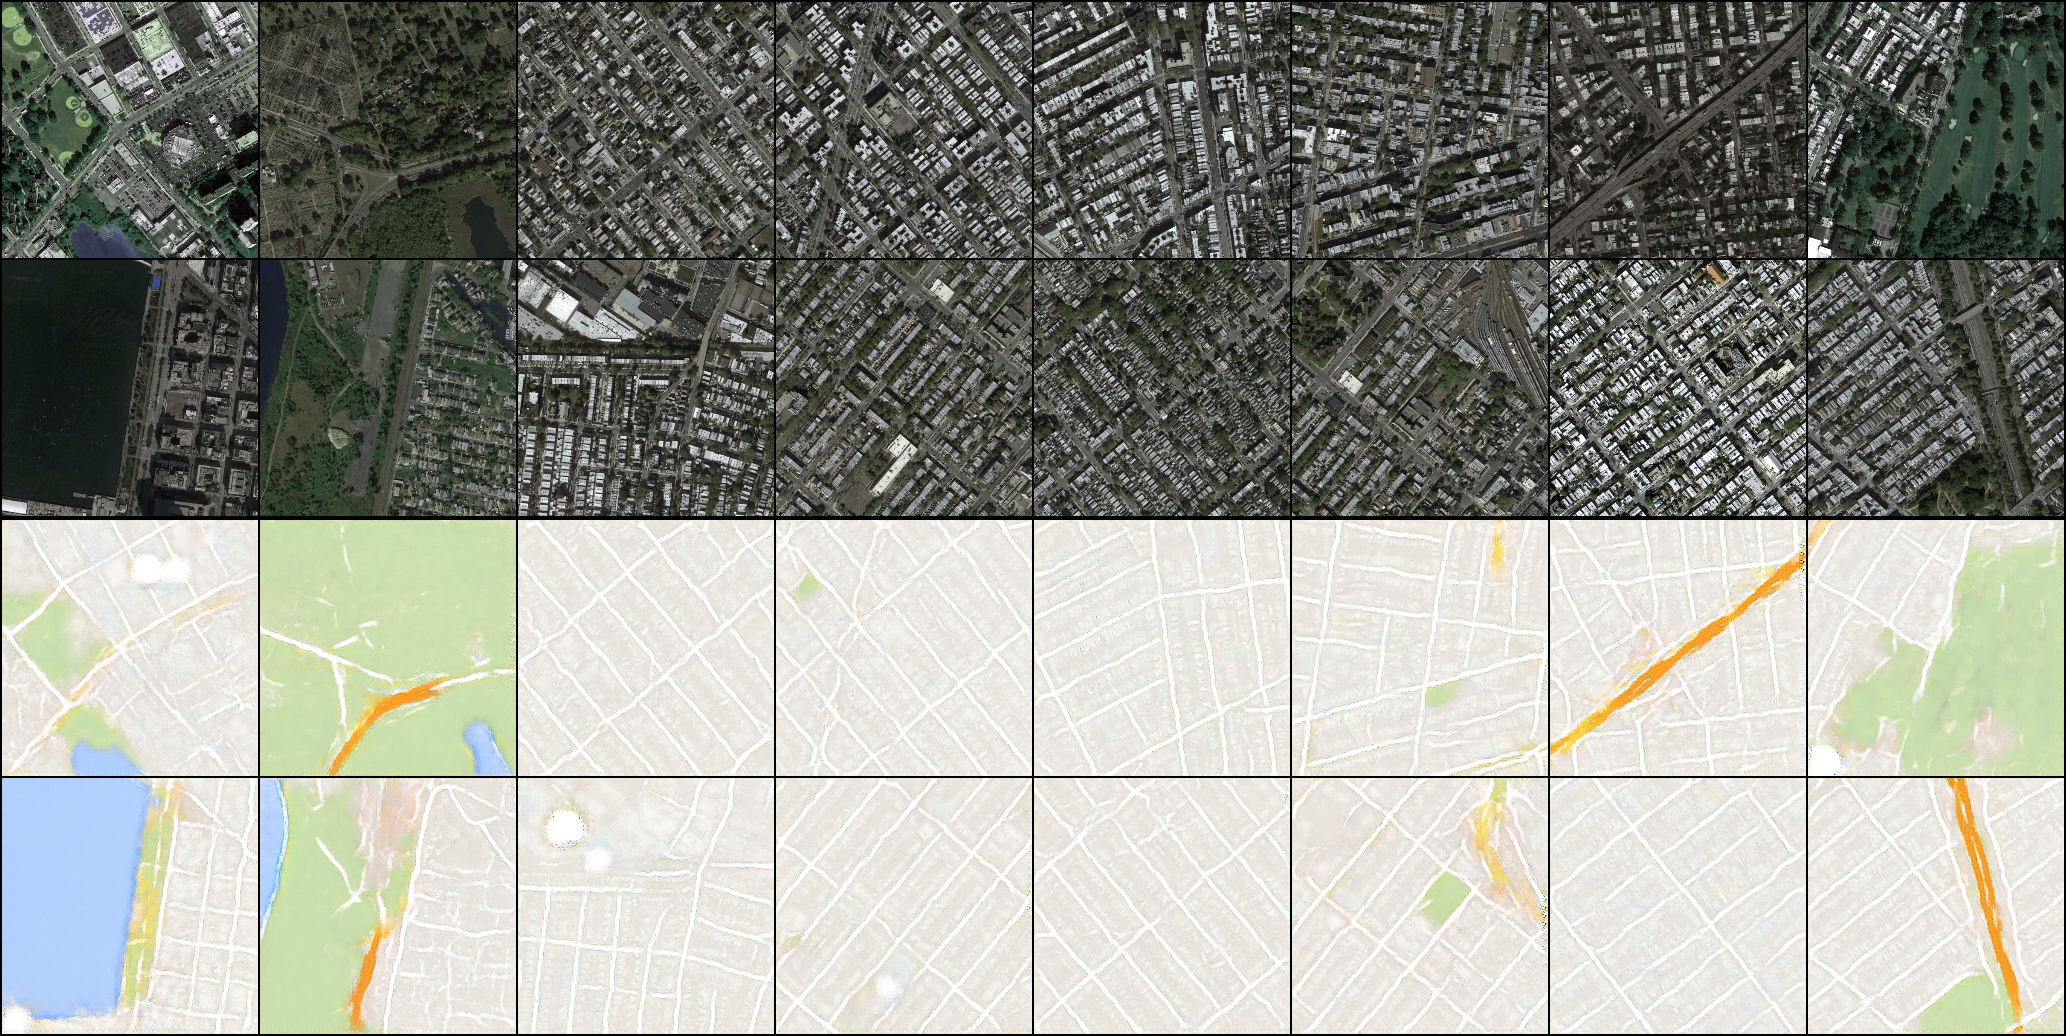

In [ ]:
get_concat_v(img_real,img_gen).show()